# Micrograd #2

In the first notebook, we implemented the backpropagation algorithm.

In [197]:
import math

class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

## Multi-layer Perceptron

In [198]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    

    def __call__(self, x):
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out
    

    def parameters(self):
        return self.w + [self.b]


x = [1.0, 2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.5007795630542308)

Let's define a layer of neurons. A layer of neurons is just a set of neurons evaluated independently.

In [199]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

To build a MLP, just assemble some layers together.

In [200]:
from typing import List

class MLP:

    def __init__(self, nin, nouts: List):
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i + 1]) for i in range(len(nouts))]


    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]


x = [1.0, 2.0, 3.0]
mlp = MLP(3, [3, 2, 1])
loss = mlp(x)

loss

Value(data=-0.13010716560275432)

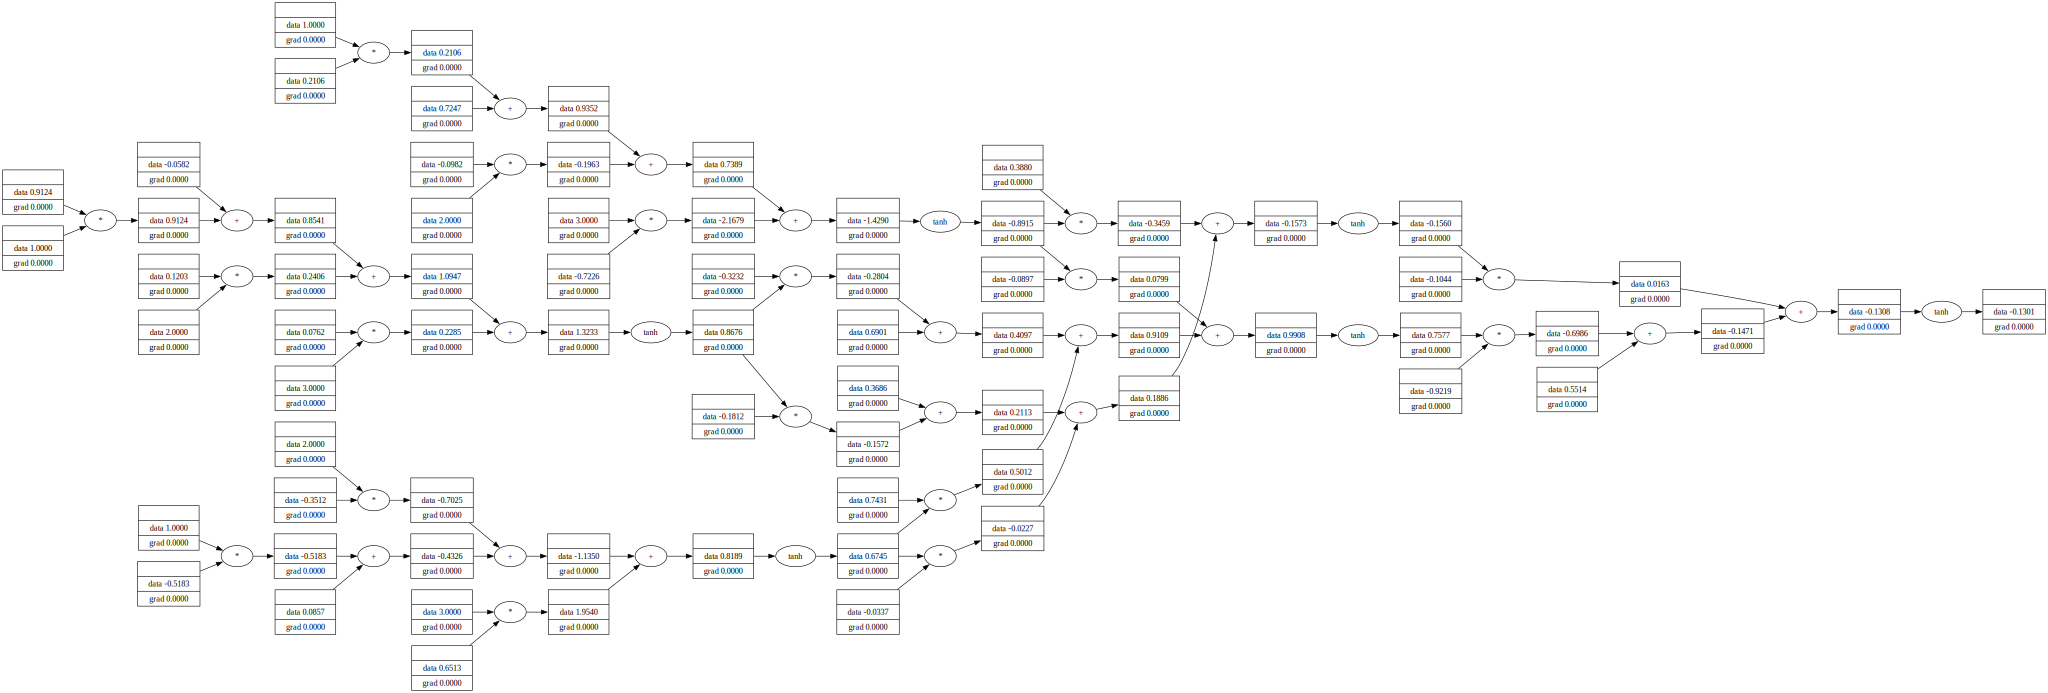

In [201]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "%s | data %.4f | grad %.4f" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

draw_dot(loss)

## Tiny dataset

First, design some input values and corresponding labels.

In [202]:
xs = [
    [1.0, 2.0, 3.0],
    [2.0, -3.0, 1.0],
    [2.0, -1.0, 3.0],
    [-3.0, -2.0, 1.0],
]
ys = [1.0, -1.0, 0.5, 1.5]

Let's perform a forward pass using this input data.

In [203]:
predictions = [mlp(x) for x in xs]
predictions

[Value(data=-0.13010716560275432),
 Value(data=-0.11079191118933698),
 Value(data=-0.171876099069501),
 Value(data=-0.34171649433071694)]

How to tweak the MLP's parameters to come closer to the ground truth? Calculate a single number that measures the accuracy of the entire MLP.

In [204]:
squared_diffs = [(ypred - ys)**2 for ys, ypred in zip(ys, predictions)]
loss = sum(squared_diffs) # a single scalar encapsulates all this info
loss

Value(data=5.911170368943679)

We want to minimize the loss. Let's run a backward pass to collect gradients.

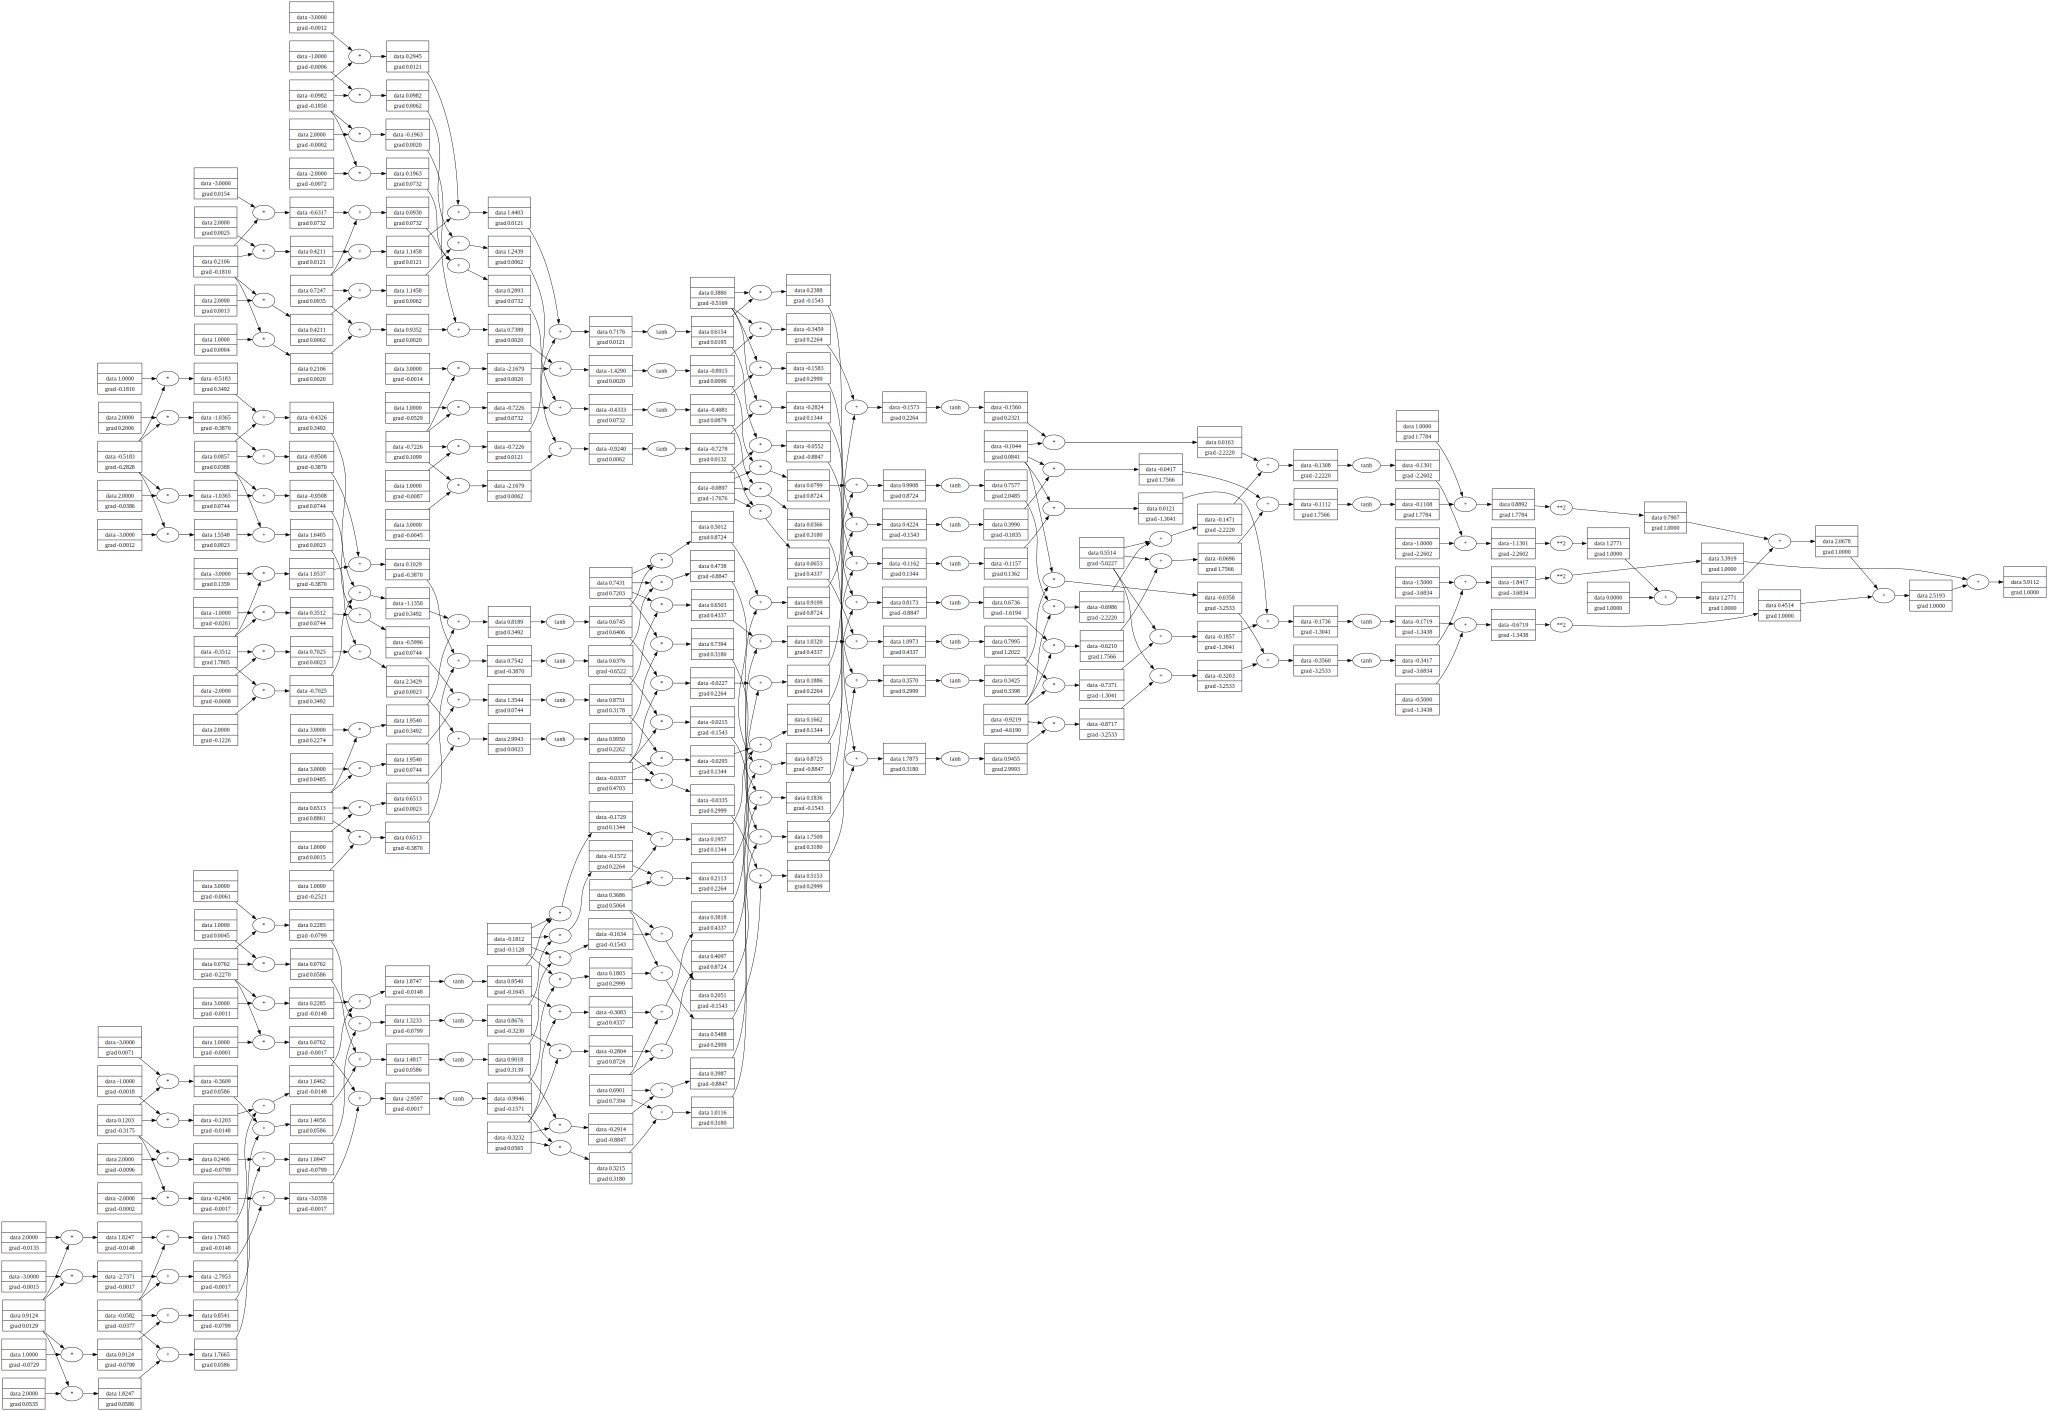

In [205]:
loss.backward()
draw_dot(loss)

Going in the direction of the gradient will increase the loss. If a gradient is negative, it should be increased to minize the loss.

In [206]:
mlp.layers[0].neurons[0].w[0].grad

0.012853544448091543

In [207]:
mlp.layers[0].neurons[0].w[0].data

0.9123514976913538

How to nudge parameters from the gradient?

In [208]:
for p in mlp.parameters():
    p.data += -0.01 * p.grad

Let's run a new forward pass.

In [209]:
predictions = [mlp(x) for x in xs]
squared_diffs = [(ypred - ys)**2 for ys, ypred in zip(ys, predictions)]
loss = sum(squared_diffs) # a single scalar encapsulates all this info
print(loss)

Value(data=5.375824548383999)


The loss value decreased :D

In [210]:
for i in range(20):
    # Forward
    predictions = [mlp(x) for x in xs]
    squared_diffs = [(ypred - ys)**2 for ys, ypred in zip(ys, predictions)]
    loss = sum(squared_diffs)

    # Zero grad
    for p in mlp.parameters():
        p.grad = 0.0

    # Backward
    loss.backward()

    # Update
    for p in mlp.parameters():
        p.data += -0.1 * p.grad
    
    print(i, loss.data)

0 5.375824548383999
1 3.5128845139491474
2 3.3195200958932833
3 3.0419684865466006
4 2.574882194191221
5 1.893847866288878
6 1.2667406423871617
7 0.8905322615513889
8 0.6933687847414414
9 0.5848195731792943
10 0.5179814153659221
11 0.47374805112573487
12 0.4434789676834461
13 0.429921913385637
14 0.42738115663368426
15 0.49612261415010517
16 0.4168599747086912
17 0.37483277910510937
18 0.39938035108934766
19 0.3639081599606293
